In [1]:
import time
import pickle
import torch
import copy
import torch.nn          as nn
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt 
import seaborn           as sns

from tqdm                   import tqdm 
from typing                 import List
from tabulate               import tabulate
from torch.utils.data       import Dataset, DataLoader
from torch_geometric.loader import DataLoader as PyG_Dataloader

from config import PATH_SUMMARY_DATASETS

torch.manual_seed(42)
sns.set_theme(style="white")

---

# Experiments on the `TabTab` approach

In this notebook we are going to expirment the approach of 
- having the cell-line branch using tabular input (`Tab`)
- having the drug branch using tabular input (`Tab`).

In [2]:
WITHOUT_MISSING_FOLDER = '/without_missing/'

## Root datasets

- The final datasets have been created in `15_summary_datasets.ipynb`

In [3]:
# Reading the cell-line gene graphs.
with open(f'{PATH_SUMMARY_DATASETS}{WITHOUT_MISSING_FOLDER}cell_line_gene_matrix.pkl', 'rb') as f:
    cl_gene_mat = pickle.load(f)

# Reading the drug SMILES fingerprint table.
with open(f'{PATH_SUMMARY_DATASETS}drug_smiles_fingerprints_matrix.pkl', 'rb') as f:
    drug_mat = pickle.load(f)

# Reading the drug response matrix.
with open(f'{PATH_SUMMARY_DATASETS}{WITHOUT_MISSING_FOLDER}drug_response_matrix__gdsc2.pkl', 'rb') as f: 
    drm = pickle.load(f)  

In [4]:
print(f"Cell-line gene matrix\n{21*'='}")
assert len([col for col in cl_gene_mat.columns[1:] if '_gexpr' in col]) == \
    len([col for col in cl_gene_mat.columns[1:] if '_cnvg' in col]) == \
    len([col for col in cl_gene_mat.columns[1:] if '_cnvp' in col]) == \
    len([col for col in cl_gene_mat.columns[1:] if '_mut' in col])
cl_gene_mat.set_index('CELL_LINE_NAME', inplace=True)    
print(cl_gene_mat.shape)
print(f"unique cell-lines: {len(cl_gene_mat.index.unique())}")
cl_gene_mat.head(3)

Cell-line gene matrix
(732, 3432)
unique cell-lines: 732


,FBXL12_gexpr,PIN1_gexpr,PAK4_gexpr,GNA15_gexpr,ARPP19_gexpr,EAPP_gexpr,MOK_gexpr,MTHFD2_gexpr,TIPARP_gexpr,CASP3_gexpr,...,PDHX_mut,DFFB_mut,FOSL1_mut,ETS1_mut,EBNA1BP2_mut,MYL9_mut,MLLT11_mut,PFKL_mut,FGFR4_mut,SDHB_mut
CELL_LINE_NAME,,,,,,,,,,,,,,,,,,,,,
22RV1,7.023759,6.067534,4.318750,3.261427,6.297582,8.313991,5.514912,10.594112,5.222366,6.635925,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
23132-87,6.714387,5.695096,4.536146,3.295886,7.021037,8.500080,4.862145,10.609245,6.528668,7.238143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42-MG-BA,7.752402,5.475753,4.033714,3.176525,7.279671,8.013367,4.957332,11.266705,7.445954,6.312424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print(f"Drug SMILES fingerprint matrix\n{30*'='}")
drug_mat.set_index('DRUG_ID', inplace=True)
print(drug_mat.shape)
print(f"unique drugs: {len(drug_mat.index.unique())}")
drug_mat.head(3)

Drug SMILES fingerprint matrix
(152, 256)
unique drugs: 152


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
DRUG_ID,,,,,,,,,,,,,,,,,,,,,
1073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1910,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1913,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [6]:
print(f"Drug response matrix\n{20*'='}")
print(drm.shape)
print(f"unique cell-lines: {len(drm.CELL_LINE_NAME.unique())}")
print(f"unique drugs     : {len(drm.DRUG_ID.unique())}")
drm.head(3)

Drug response matrix
(91991, 5)
unique cell-lines: 732
unique drugs     : 152


,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,DATASET,LN_IC50
3441054,22RV1,1003,Camptothecin,GDSC2,-3.142631
3459252,22RV1,1004,Vinblastine,GDSC2,-4.459259
3508920,22RV1,1006,Cytarabine,GDSC2,3.826935


## Create `PyTorch` dataset

In [7]:
from torch_geometric.data import Dataset as PyGDataset

class TabTabDataset(PyGDataset):
    def __init__(self, cl_mat, drug_mat, drm):
        super().__init__()
        self.cl_mat = cl_mat
        self.drug_mat = drug_mat

        drm.reset_index(drop=True, inplace=True)
        self.cls = drm['CELL_LINE_NAME']
        self.drug_ids = drm['DRUG_ID']
        self.drug_names = drm['DRUG_NAME']
        self.ic50s = drm['LN_IC50']

    def __len__(self):
        return len(self.ic50s)

    def __getitem__(self, idx: int):
        """
        Returns a tuple of cell-line-gene features, drug smiles fingerprints 
        and the corresponding ln(IC50) values for a given index.

        Args:
            idx (`int`): Index to specify the row in the drug response matrix.  
        Returns
            `Tuple[np.ndarray, np.ndarray, np.float64]]`: Tuple of cell-line 
                gene feature values, drug SMILES fingerprints and the 
                corresponding ln(IC50) target values.
        """
        return (self.cl_mat.loc[self.cls.iloc[idx]], 
                self.drug_mat.loc[self.drug_ids.iloc[idx]],
                self.ic50s.iloc[idx])

    def print_summary(self):
        print(f"TabTabDataset Summary")
        print(21*'=')
        print(f"# observations :", len(self.ic50s))
        print(f"# cell-lines   :", len(np.unique(self.cls)))
        print(f"# drugs        :", len(np.unique(self.drug_names)))
        print(f"# genes        :", len([col for col in self.cl_mat.columns[1:] if '_cnvg' in col]))

In [8]:
tab_tab_dataset = TabTabDataset(cl_mat=cl_gene_mat, drug_mat=drug_mat, drm=drm)
tab_tab_dataset.print_summary()

TabTabDataset Summary
# observations : 91991
# cell-lines   : 732
# drugs        : 152
# genes        : 858


## Hyperparameters

In [9]:
class Args:
    def __init__(self, batch_size, lr, train_ratio, val_ratio, num_epochs):
        self.BATCH_SIZE = batch_size
        self.LR = lr
        self.TRAIN_RATIO = train_ratio
        self.TEST_VAL_RATIO = 1-self.TRAIN_RATIO
        self.VAL_RATIO = val_ratio
        self.NUM_EPOCHS = num_epochs
        self.RANDOM_SEED = 12345      

args = Args(batch_size=1_000, 
            lr=0.0001, 
            train_ratio=0.8, 
            val_ratio=0.5, 
            num_epochs=300)


## Create `DataLoader` datasets

In [12]:
print(drm.isna().any())
print(cl_gene_mat.isna().any())
print(drug_mat.isna().any())

CELL_LINE_NAME    False
DRUG_ID           False
DRUG_NAME         False
DATASET           False
LN_IC50           False
dtype: bool
FBXL12_gexpr    False
PIN1_gexpr      False
PAK4_gexpr      False
GNA15_gexpr     False
ARPP19_gexpr    False
                ...  
MYL9_mut        False
MLLT11_mut      False
PFKL_mut        False
FGFR4_mut       False
SDHB_mut        False
Length: 3432, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
251    False
252    False
253    False
254    False
255    False
Length: 256, dtype: bool


In [13]:
cl_gene_mat.isna().sum().head(860)

FBXL12_gexpr    0
PIN1_gexpr      0
PAK4_gexpr      0
GNA15_gexpr     0
ARPP19_gexpr    0
               ..
PFKL_gexpr      0
FGFR4_gexpr     0
SDHB_gexpr      0
FBXL12_cnvg     0
PIN1_cnvg       0
Length: 860, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def _collate_tab_tab(samples):
    cls, drugs, ic50s = map(list, zip(*samples))
    cls = [torch.tensor(cl, dtype=torch.float64) for cl in cls]
    drugs = [torch.tensor(drug, dtype=torch.float64) for drug in drugs]
    # print("\nCELL-LINES: ", cls[0])
    # print("\nDRUG:", drugs[0])
    # print("\nIC50: ", ic50s[0])
    
    return torch.stack(cls, 0), torch.stack(drugs, 0), torch.tensor(ic50s)

def create_datasets(drm, cl_mat, drug_mat):
    train_set, test_val_set = train_test_split(drm, test_size=args.TEST_VAL_RATIO, random_state=args.RANDOM_SEED, stratify=drm['CELL_LINE_NAME'])
    test_set, val_set = train_test_split(test_val_set, test_size=args.VAL_RATIO, random_state=args.RANDOM_SEED, stratify=test_val_set['CELL_LINE_NAME'])

    print("train_set.shape:", train_set.shape)
    print("test_set.shape:", test_set.shape)
    print("val_set.shape:", val_set.shape)

    train_dataset = TabTabDataset(cl_mat=cl_mat, drug_mat=drug_mat, drm=train_set)
    test_dataset = TabTabDataset(cl_mat=cl_mat, drug_mat=drug_mat, drm=test_set)
    val_dataset = TabTabDataset(cl_mat=cl_mat, drug_mat=drug_mat, drm=val_set)

    print("\ntrain_dataset"); train_dataset.print_summary()
    print("\ntest_dataset"); test_dataset.print_summary()
    print("\nval_dataset"); val_dataset.print_summary()

    train_loader = DataLoader(dataset=train_dataset, batch_size=args.BATCH_SIZE, shuffle=True, collate_fn=_collate_tab_tab)
    test_loader = DataLoader(dataset=test_dataset, batch_size=args.BATCH_SIZE, shuffle=True, collate_fn=_collate_tab_tab)
    val_loader = DataLoader(dataset=val_dataset, batch_size=args.BATCH_SIZE, shuffle=True, collate_fn=_collate_tab_tab)

    return train_loader, test_loader, val_loader

train_loader, test_loader, val_loader = create_datasets(drm, cl_gene_mat, drug_mat)    

train_set.shape: (73592, 5)
test_set.shape: (9199, 5)
val_set.shape: (9200, 5)

train_dataset
TabTabDataset Summary
# observations : 73592
# cell-lines   : 732
# drugs        : 152
# genes        : 858

test_dataset
TabTabDataset Summary
# observations : 9199
# cell-lines   : 732
# drugs        : 152
# genes        : 858

val_dataset
TabTabDataset Summary
# observations : 9200
# cell-lines   : 732
# drugs        : 152
# genes        : 858


In [11]:
print("Number of batches per dataset:")
print(f"  train : {len(train_loader)}")
print(f"  test  : {len(test_loader)}")
print(f"  val   : {len(val_loader)}")

Number of batches per dataset:
  train : 74
  test  : 10
  val   : 10


In [12]:
tab_tab_dataset[1]

(FBXL12_gexpr    7.023759
 PIN1_gexpr      6.067534
 PAK4_gexpr      4.318750
 GNA15_gexpr     3.261427
 ARPP19_gexpr    6.297582
                   ...   
 MYL9_mut        0.000000
 MLLT11_mut      1.000000
 PFKL_mut        0.000000
 FGFR4_mut       1.000000
 SDHB_mut        0.000000
 Name: 22RV1, Length: 3432, dtype: float64,
 0      1
 1      0
 2      0
 3      0
 4      0
       ..
 251    1
 252    0
 253    0
 254    0
 255    0
 Name: 1004, Length: 256, dtype: int64,
 -4.459259)

In [13]:
for step, data in enumerate(train_loader):
    if (step > 2) & (step < len(train_loader)-1):
        if step % 10 == 0: 
            print("... step", step) 
        continue
    else:
        cl_mat, drug_mat, ic50s = data
        print(f'Step {step + 1}:')
        print(f'=======')    
        print(cl_mat.shape)
        print(drug_mat.shape)
        print(ic50s.shape)

Step 1:
torch.Size([1000, 3432])
torch.Size([1000, 256])
torch.Size([1000])
Step 2:
torch.Size([1000, 3432])
torch.Size([1000, 256])
torch.Size([1000])
Step 3:
torch.Size([1000, 3432])
torch.Size([1000, 256])
torch.Size([1000])
... step 10
... step 20
... step 30
... step 40
... step 50
... step 60
... step 70
Step 74:
torch.Size([592, 3432])
torch.Size([592, 256])
torch.Size([592])


## Model development

In [12]:
from tqdm import tqdm
from time import sleep
import torch.nn.functional as F
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr


class BuildModel:
    def __init__(self, model, criterion, optimizer, num_epochs, 
        train_loader, test_loader, val_loader, device):
        self.train_losses = []
        self.test_losses = []
        self.val_losses = []
        self.train_loader = train_loader 
        self.test_loader = test_loader
        self.val_loader = val_loader
        self.num_epochs = num_epochs
        self.model = model 
        self.criterion = criterion
        self.optimizer = optimizer 
        self.device = device

    def train(self, loader): 
        train_epoch_losses, val_epoch_losses = [], []
        all_batch_losses = [] # TODO: this is just for monitoring
        n_batches = len(loader)
        for epoch in range(self.num_epochs): 
            self.model.train()
            # print("=====Epoch ", epoch, " | Training...")
            batch_losses = []
            for data in tqdm(loader, desc='Iter', position=0, leave=True):
                sleep(0.01)
                cl, dr, ic50 = data
                cl, dr, ic50 = cl.to(self.device), dr.to(self.device), ic50.to(self.device)
                # print("cl: ", cl.shape, cl); print("dr: ", dr.shape, dr); print("ic50: ", y.shape, y)

                self.optimizer.zero_grad()                

                preds = self.model(cl.float(), dr.float()).unsqueeze(1) # TODO: unsqueeze can be added to forward
                # print(preds.shape)
                # print("preds:", preds)
                loss = self.criterion(preds, ic50.view(-1,1).float())
                batch_losses.append(loss)

                loss.backward()
                self.optimizer.step()
            # print(batch_losses)
            all_batch_losses.append(batch_losses) # TODO: this is just for monitoring
            total_epoch_loss = sum(batch_losses)
            train_epoch_losses.append(total_epoch_loss / n_batches)

            mse, _, _, _, _ = self.validate(val_loader)
            val_epoch_losses.append(mse)

            if epoch % 25 == 0:
                print("=====Epoch ", epoch)
                print(f"Train      | MSE: {train_epoch_losses[-1]:2.5f}")
                print(f"Validation | MSE: {mse:2.5f}")

        return train_epoch_losses, val_epoch_losses

    def validate(self, loader):
        self.model.eval()
        y_true, y_pred = [], []
        total_loss = 0
        with torch.no_grad():
            for data in tqdm(loader, desc='Iter', position=0, leave=True):
                sleep(0.01)
                cl, dr, ic50 = data

                preds = self.model(cl.float(), dr.float()).unsqueeze(1)
                ic50 = ic50.to(self.device)
                total_loss += self.criterion(preds, ic50.view(-1,1).float())
                # total_loss += F.mse_loss(preds, ic50.view(-1, 1).float(), reduction='sum')
                y_true.append(ic50.view(-1, 1))
                y_pred.append(preds)
        
        y_true = torch.cat(y_true, dim=0)
        y_pred = torch.cat(y_pred, dim=0)
        mse = total_loss / len(loader)
        rmse = torch.sqrt(mse)
        mae = mean_absolute_error(y_true.cpu(), y_pred.cpu())
        r2 = r2_score(y_true.cpu(), y_pred.cpu())
        pearson_corr_coef, _ = pearsonr(y_true.cpu().numpy().flatten(), 
                                        y_pred.cpu().numpy().flatten())

        return mse, rmse, mae, r2, pearson_corr_coef


In [13]:
%load_ext autoreload
%autoreload

# from TabTab import TabTabModel

class TabTabModel(nn.Module):
    def __init__(self):
        super(TabTabModel, self).__init__()
        self.cell_branch = nn.Sequential(
            nn.Linear(3432, 516),
            nn.BatchNorm1d(516),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(516, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()         
        )

        self.drug_branch = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU()          
        )

        self.fcn = nn.Sequential(
            nn.Linear(2*128, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Linear(64, 1)
            # nn.BatchNorm1d(1),
            # nn.ReLU()
        )     

    def forward(self, cell, drug):
        cell_emb = self.cell_branch(cell)  # Create cell gene vector embedding.
        drug_emb = self.drug_branch(drug)  # Create compound vector embedding.
        # print("cell_emb: ", cell_emb.shape)
        # print("drug_emb: ", drug_emb.shape)

        concat = torch.cat([cell_emb, drug_emb], 1)
        # print(concat.shape)
        # print(concat)

        # x_dim_batch, y_dim_branch, z_dim_features = concat.shape[0], concat.shape[1], concat.shape[2]
        # concat = torch.reshape(concat, (x_dim_batch, y_dim_branch*z_dim_features))
        
        y_pred = self.fcn(concat)
        y_pred = y_pred.reshape(y_pred.shape[0])
        return y_pred

torch.manual_seed(args.RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

model = TabTabModel().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=args.LR)

build_model = BuildModel(model, loss_func, optimizer, args.NUM_EPOCHS, 
                         train_loader, test_loader, val_loader,
                         device)

device: cpu


In [14]:
train_losses, val_losses = build_model.train(build_model.train_loader)

tr_mse, tr_rmse, tr_mae, tr_r2, tr_r = build_model.validate(build_model.train_loader)
val_mse, val_rmse, val_mae, val_r2, val_r = build_model.validate(build_model.val_loader)
te_mse, te_rmse, te_mae, te_r2, te_r = build_model.validate(build_model.test_loader)

results = tabulate(
    [
        ['mse', 'rmse', 'mae', 'r2', 'r'],
        ['train', tr_mse, tr_rmse, tr_mae, tr_r2, tr_r],
        ['validation', val_mse, val_rmse, val_mae, val_r2, val_r],
        ['test', te_mse, te_rmse, te_mae, te_r2, te_r]
    ], headers='firstrow')
print(results)

Iter: 100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


=====Epoch  0
Train      | MSE: 10.92296
Validation | MSE: 7.30963


Iter: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


=====Epoch  25
Train      | MSE: 1.31992
Validation | MSE: 1.23547


Iter: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


=====Epoch  50
Train      | MSE: 1.08509
Validation | MSE: 1.00775


Iter: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


=====Epoch  75
Train      | MSE: 0.98334
Validation | MSE: 0.96934


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


=====Epoch  100
Train      | MSE: 0.92735
Validation | MSE: 0.91169


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


=====Epoch  125
Train      | MSE: 0.87510
Validation | MSE: 0.92339


Iter: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


=====Epoch  150
Train      | MSE: 0.83066
Validation | MSE: 0.88861


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


=====Epoch  175
Train      | MSE: 0.79286
Validation | MSE: 0.85819


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


=====Epoch  200
Train      | MSE: 0.76515
Validation | MSE: 0.86072


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


=====Epoch  225
Train      | MSE: 0.73852
Validation | MSE: 0.82977


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


=====Epoch  250
Train      | MSE: 0.71375
Validation | MSE: 0.83597


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


=====Epoch  275
Train      | MSE: 0.69882
Validation | MSE: 0.81370


Iter: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

                 mse      rmse       mae        r2         r
----------  --------  --------  --------  --------  --------
train       0.450149  0.670932  0.51781   0.938216  0.968843
validation  0.811576  0.900875  0.662914  0.889404  0.943088
test        0.83026   0.911186  0.669223  0.886715  0.941691


```
n_epochs = 100
    mse     rmse       mae        r2         r
-------  -------  --------  --------  --------
1.34979  1.1618   0.580942  0.814719  0.92687
2.09012  1.44572  0.981567  0.709278  0.858571
2.14415  1.46429  0.983369  0.709229  0.857674

n_epochs = 300
                 mse      rmse       mae        r2         r
----------  --------  --------  --------  --------  --------
train       0.450149  0.670932  0.51781   0.938216  0.968843
validation  0.811576  0.900875  0.662914  0.889404  0.943088
test        0.83026   0.911186  0.669223  0.886715  0.941691
```

In [17]:
results = tabulate(
    [
        ['mse', 'rmse', 'mae', 'r2', 'r'],
        ['train', tr_mse, tr_rmse, tr_mae, tr_r2, tr_r],
        ['validation', val_mse, val_rmse, val_mae, val_r2, val_r],
        ['test', te_mse, te_rmse, te_mae, te_r2, te_r]
    ], headers='firstrow')
print(results)

                 mse      rmse       mae        r2         r
----------  --------  --------  --------  --------  --------
train       0.450149  0.670932  0.51781   0.938216  0.968843
validation  0.811576  0.900875  0.662914  0.889404  0.943088
test        0.83026   0.911186  0.669223  0.886715  0.941691


### EDA on Model

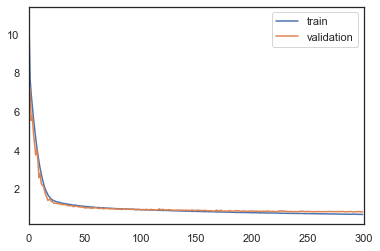

In [16]:
plt.plot([loss.item() for loss in train_losses], c='C0', label='train');
plt.plot([loss.item() for loss in val_losses], c='C1', label='validation');
plt.legend();
plt.ticklabel_format(style='plain');
plt.xlim(0, args.NUM_EPOCHS, 1);

### Save Model

In [18]:
torch.save(build_model.model.state_dict(), '../../datasets/models/TabTab_v1.pt')

In [28]:
ls -lh ../../datasets/models

total 95264
-rw-r--r--  1 cwoest  staff   8.1M Sep 28 13:52 Model2CnvGistic__cnv_gistic.pkl
-rw-r--r--  1 cwoest  staff   8.1M Sep 28 14:37 Model2CnvGistic__cnv_picnic.pkl
-rw-r--r--  1 cwoest  staff   7.8M Nov 11 19:03 TabTab_v1.pkl
-rw-r--r--  1 cwoest  staff   7.8M Nov 11 19:04 TabTab_v1.pt
-rw-r--r--  1 cwoest  staff   8.1M Sep 28 13:12 model2.pkl
-rw-r--r--  1 cwoest  staff   1.3M Aug 24 16:00 simpleNN
-rw-r--r--  1 cwoest  staff   1.3M Aug 24 15:58 simpleNN.pkl
-rw-r--r--  1 cwoest  staff   4.0M Aug 24 16:03 simpleNN_extensive.pkl


### Load Model

In [30]:
loaded_model = TabTabModel()
loaded_model.load_state_dict(torch.load('../../datasets/models/TabTab_v1.pt'))
loaded_model.eval()

TabTabModel(
  (cell_branch): Sequential(
    (0): Linear(in_features=3432, out_features=516, bias=True)
    (1): BatchNorm1d(516, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=516, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (drug_branch): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [82]:
outs = []
os = 0
for i in range(5):

    loss = nn.MSELoss()
    input = torch.randn(3, 5, requires_grad=True)
    target = torch.randn(3, 5)
    output = loss(input, target)
    outs.append(output)
    os += output
    output.backward()
print(sum(outs))
print(os)
outs



tensor(10.2950, grad_fn=<AddBackward0>)
tensor(10.2950, grad_fn=<AddBackward0>)


[tensor(0.9803, grad_fn=<MseLossBackward0>),
 tensor(2.1797, grad_fn=<MseLossBackward0>),
 tensor(3.0829, grad_fn=<MseLossBackward0>),
 tensor(2.1547, grad_fn=<MseLossBackward0>),
 tensor(1.8975, grad_fn=<MseLossBackward0>)]

In [81]:
sum(outs)

tensor(13.1052, grad_fn=<AddBackward0>)